
=== Discrete-probability RL ===
Mean attendance (last 100): 67.82
Mean chosen p (last 100): 0.677


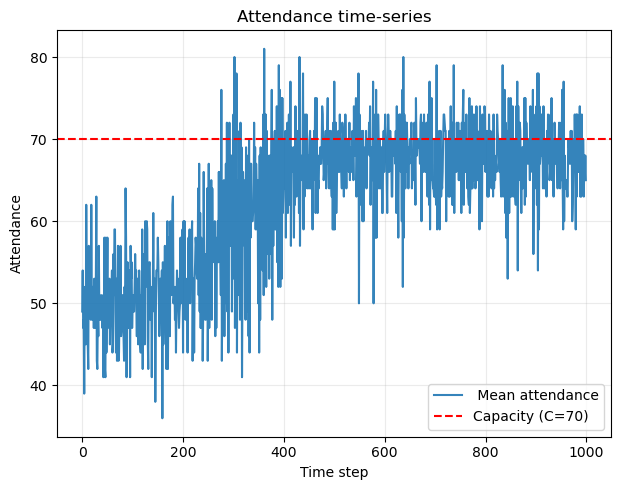

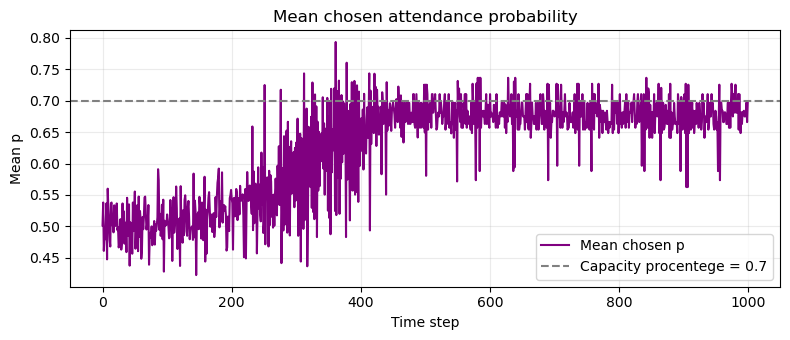

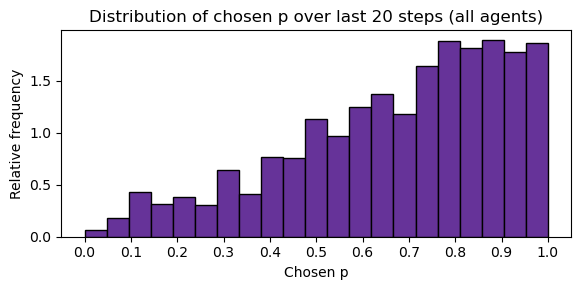

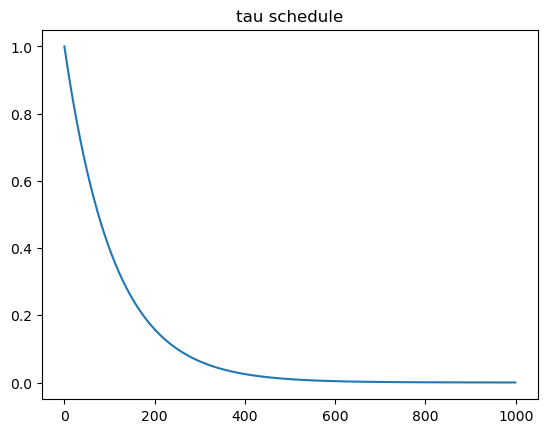

In [332]:
"""
El Farol Bar Problem 

"""

import random, math
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# PARAMETERS 
# ---------------------------------------------------------------------
# Common
SEED = 404 #golden seed 404
np.random.seed(SEED)

# Game / environment
N = 100            # number of agents
C_frac = 0.7      # capacity as fraction of population
C = int(C_frac * N)  # bar capacity
T = 1000         # number of rounds / time steps

# Payoffs
G = 8.0   # payoff for attending when not overcrowded
S = 2.0   # payoff for staying home
F = 0.5   # payoff for attending when overcrowded

# Punishment parameters
rho = 0.1 #PREV 0.1 - if rho is equal to 0.6 then some person gets negative payoff on average and the atendece because sligtly closer to the capasity
alpha = 1.3 #PREV 1.3
theta_cap = 1000
bar_theta = 0.8
beta = 0.5  

# RL parameters
M = 20          # discretization steps: actions = 0..M (p = a/M) there will be M+1 many probability levels cus also 0
LR = 0.01       # Q-learning rate - to high learning rate means that convergens happens too quicly and all of the space in the bar might not be utilized
GAMMA = 0.7     # discount factor
K_INIT = 0.1    # initial Q value range
# ---------------------------------------------------------------------

# --- Temperature schedule parameters ---
TAU_START = 1.0      # initial exploration temperature
TAU_MIN = 0.0001       # minimal exploration


# -------------------------
# Discrete-probability RL
# -------------------------
def softmax(x, tau):
    #Boltzmann (softmax) policy, which converts Q-values into action probabilities - x is vector of q-values (consites of action and state)
    z = x / tau
    z -= np.max(z) #just numerical stability
    expz = np.exp(z) # Exponential weighting
    return expz / expz.sum() #Normalization constant (sum over all actions)


def bin_theta(theta):
    #Binning θ turns a continuous, potentially huge variable into a small, learnable categorical feature that makes Q-learning practical and stable.
    """Binning for Theta - maps the order of magnitude of theta to an integer “bin”"""
    if theta <= 0:
        return 0
    return min(int(math.log10(theta + 1e-9) + 1), 6) # ensures that the Q-tables has a discrete and hashable keys


def make_state(A):
    """State representation"""
    a_int = int(A)
    return (a_int)


def run_discrete_prob_rl(G=G, S=S, F=F, N=N, C=C, T=T, M=M, lr=LR, gamma=GAMMA,
                         tau_start=TAU_START, tau_min=TAU_MIN,
                         rho=rho, alpha=alpha, beta=beta, bar_theta=bar_theta,
                         theta_cap=theta_cap, k_init=K_INIT):
    
    """Discrete-probability RL model"""
    Q_tables = [dict() for _ in range(N)] #makes N dicts - each maps the discreate state representet as a Q-vector of length M+1.
    last_actual = np.random.binomial(1, 0.5, size=N) #It represents the previous actions (attendance) of the agents before the simulation begins (i put 50/50)
    theta_i = np.array([bar_theta if a == 0 else 0.0 for a in last_actual], dtype=float) #if agent’s initial action was 0, set theta = bar_theta, else 0.0 for all the N actions in last_actual.
    #Theta = theta_i.sum() #just the sum used for payoff

    def q_get(qdict, s):
        #Returns the Q-vector for state s stored in qdict (an agent’s Q-table).
        #If s is absent, initializes a new random Q-vector uniformly in [0, k_init) of length M+1.

        #q_get initialises Q-values randomly in [0, k_init). This introduces stochasticity and exploration early on.

        if s not in qdict:
            qdict[s] = np.random.uniform(0, k_init, size=M + 1)
        return qdict[s]

    attendance_ts = [] #(list of attendance counts over time),
    mean_p_ts = [] #(mean of chosen probabilities each timestep),
    chosen_action_counts = np.zeros((N, M + 1), dtype=int) #(N x (M+1) counts of how many times each index chosen),
    chosen_history = np.zeros((T, N), dtype=int)  # (T x N array storing chosen indices each time step) KINDA BIG.
    attendance_var_ts = [] #new: create list of varianses
    avg_payoff_ts = []              # NEW: track average payoff each timestep
    all_payoffs = np.zeros((T, N))  # NEW: record individual payoffs each timestep
    p_var = []


    # Compute decay rate so tau(T-1) ≈ tau_min - makes sure it is not negative
    if tau_min <= 0 or tau_start <= 0:
        raise ValueError("tau_start and tau_min must be > 0")
    
    TAU_DECAY = -math.log(tau_min / tau_start) / max(1, (T - 1)) #this makes sure that they tau is reaches the min at the end of the run and not befor 
    # the line computes the exact exponential decay rate such that tau_t decreases smoothly from tau_start to tau_min across the simulation duration T.
    #this could be chanced to a fixed number 

    tau_history = [] # for plotting

    for t in range(T):
        #THE LOOP BEGINS 
        tau_t = max(tau_min, tau_start * math.exp(-TAU_DECAY * t)) #update tau acording so boltzman softmax - make exponential decreas
        tau_history.append(tau_t) #for plotting

        A_prev = attendance_ts[-1] if t > 0 else int(N * 0.1) #previous attendance (use 10% of N as initial attendance at t=0). WHY 0.1
        state = make_state(A_prev) #RETURNS PREVIAUS STATE AS INTEGER AND THETA (JUST BINED)

        actions = np.zeros(N, dtype=int)
        chosen_idxs = np.zeros(N, dtype=int)

        for i in range(N): # for each player
            qvec = q_get(Q_tables[i], state) #get state representation for player i aka their q-table in a givn state ( stat consisting of prev atendens and theta) - get q value for each posible k
            probs = softmax(qvec, tau=tau_t) #softmax converts Q-values into a categorical distribution over indices 0..M. Temperature tau controls exploration vs exploitation - probs vector sums to 1
            if np.any(np.isnan(probs)) or probs.sum() <= 0:
                # fallback to uniform if numerical issue
                probs = np.ones(M + 1) / (M + 1)
            idx = np.random.choice(np.arange(M + 1), p=probs) #idx is the chosen discrete index; stored in chosen_idxs[i] and increments chosen_action_counts[i, idx]. 
            # idx is a random choice, but weighted by the current Q-values. It’s not purely random; it’s probabilistic action selection guided by the learned Q-values.
            #the probability of choosing index k is exactly probs[k].
            chosen_idxs[i] = int(idx)
            chosen_action_counts[i, idx] += 1 #help - for hist i think
            

        p_vec = chosen_idxs / float(M) #The chosen index is mapped to a probability p = idx / M
        #the intended probability of taking the actual action = 1. Then the agent actually samples action ~ Bernoulli(p).

        for i in range(N):
            actions[i] = np.random.binomial(1, p_vec[i]) #Then action (0 or 1) is sampled for each agent with that probability P.

        chosen_history[t, :] = chosen_idxs  # stores the chosen discrete index for each agent each time step.
        A_t = actions.sum() #SUM OF ACTIONS ALSO ATENTES CUZ 1 AND 0 ARE NICE TO WORK WITH
        attendance_ts.append(A_t) #attendance counts over time (sum of binary actions) USED TO PLOT 
        mean_p_ts.append(p_vec.mean()) #average of the p_vec across agents each timestep.
        attendance_var_ts.append(float(np.var(actions))) #new: add varians of the actions/attendance 
        p_var.append(float(np.var(p_vec)))  #trying new varians plot
        

        # Update theta
        new_theta = np.zeros_like(theta_i)

        for i in range(N): # for all players:
            # If agent did not go now (action==0) and also did not go previously (last_actual==0): 
            # theta increases from prev by rho * prev**alpha, capped by theta_cap. 
            # If prev was 0, it uses bar_theta as starting value. HELP

            if actions[i] == 0 and last_actual[i] == 0:
                prev = theta_i[i] if theta_i[i] > 0 else bar_theta
                new_val = prev + rho * (prev ** alpha)
                new_theta[i] = min(new_val, theta_cap)
            elif actions[i] == 0 and last_actual[i] == 1:
                #If agent did not go now but went previously (last_actual==1), reset theta to bar_theta
                new_theta[i] = bar_theta
            else:
                #If agent just went (action==1), set theta to 0.
                new_theta[i] = 0.0
        theta_i = new_theta #why - I dont get the shape why is it not inside loop i am confution CANT JUST GO INTO REWARD EITHER --> Sad
        
        

        # Rewards
        rewards = np.zeros(N, dtype=float)
        for i in range(N):
            if actions[i] == 1:
                # If an agent chooses to go, payoff depends on how many other agents chose to go:
                # If others < C → payoff = G.
                # If others >= C → payoff = F.
                others = A_t - 1
                payoff = G if others < C else F
            else:
                #If agent chooses 0, payoff is S
                payoff = S
            rewards[i] = payoff - beta * theta_i[i] #rewars are just the sum of payoff and penalty 

        # Record average payoff and store payoffs for histogram later
        avg_payoff_ts.append(rewards.mean())   # mean payoff at this timestep
        all_payoffs[t, :] = rewards            # save payoffs of all agents at time t


        next_state = make_state(A_t)
        for i in range(N):
            #the actual q-learning 
            qdict = Q_tables[i] #is the agent’s personal Q-table - The key is the current environment state - The value is the vector of Q-values for all possible discrete actions (M+1 of them).
            qvec = q_get(qdict, state)
            next_qvec = q_get(qdict, next_state)
            aidx = chosen_idxs[i] #this is player i's current indet (could also just be p*M and thik of M as 100 even when it isnt)
            r = rewards[i]
            qvec[aidx] += lr * (r + gamma * np.max(next_qvec) - qvec[aidx]) #Standard one-step Q-learning update: Q(s, a) ← Q(s, a) + α [ r + γ max_a' Q(s', a') − Q(s, a) ].
            qdict[state] = qvec #Q-table is updated in-place in Q_tables[i][state]. aka store the updated Q-values qvec for this particular state in the agent’s Q-table
            # the q values can be thought of as: what the agent has learned about which idx (probability of acting) works best in each state. where the state is represented as the atendence as well as the size of theta
            
        last_actual = actions.copy() #Each last_actual[i] indicates whether agent i was “attending” (1) or “not attending” (0) at the previous time step (t = -1).
        # the .copy just allows you to put new actions next time step and then save them agian ones you are dome



    return {
        "attendance_ts": np.array(attendance_ts),
        "mean_p_ts": np.array(mean_p_ts),
        "chosen_action_counts": chosen_action_counts,
        "chosen_history": chosen_history,
        "final_theta": theta_i,
        "final_Q_tables": Q_tables,
        "attendance_var_ts": np.array(attendance_var_ts),   # NEW
        "avg_payoff_ts": np.array(avg_payoff_ts),    # NEW
        "all_payoffs": np.array(all_payoffs),         # NEW
        "tau_history": np.array(tau_history),   
        "p_var": np.array(p_var)
    }


# -------------------------
# Run both models and plot
# -------------------------
if __name__ == "__main__":

    print("\n=== Discrete-probability RL ===")

    res = run_discrete_prob_rl(G=G, S=S, F=F, N=N, C=C, T=1000, M=M, lr=LR, gamma=GAMMA, 
                               tau_start=TAU_START, tau_min=TAU_MIN,
                         rho=rho, alpha=alpha, beta=beta, bar_theta=bar_theta,
                         theta_cap=theta_cap, k_init=K_INIT)
    
    
    att_rl = res["attendance_ts"]
    mean_p = res["mean_p_ts"]
    print(f"Mean attendance (last 100): {att_rl[-100:].mean():.2f}")
    print(f"Mean chosen p (last 100): {mean_p[-100:].mean():.3f}")

    # ---- PLOTS ----
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 2)
    plt.plot(att_rl, label=" Mean attendance", alpha=0.9)
    plt.axhline(C, color='r', linestyle='--', label=f'Capacity (C={C})')
    plt.title("Attendance time-series")
    plt.xlabel("Time step")
    plt.ylabel("Attendance")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

    # Mean chosen probability (RL)
    plt.figure(figsize=(8, 3.5))
    plt.plot(mean_p, label='Mean chosen p', color='purple')
    plt.axhline(C_frac, color='gray', linestyle='--', label=f'Capacity procentege = {C_frac}')
    plt.title("Mean chosen attendance probability")
    plt.xlabel("Time step")
    plt.ylabel("Mean p")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

    # Histogram: distribution of chosen p's in final window
    chosen_hist = res["chosen_history"]
    final_window = 20 # do spisific numbers to see what happens at what times in the learning
    M = chosen_hist.max()
    w = min(final_window, chosen_hist.shape[0])
    flat_idxs = chosen_hist[-w:, :].flatten() #help
    p_values = flat_idxs / M

    plt.figure(figsize=(6, 3))
    plt.hist(p_values, bins=M + 1, edgecolor='black', color='rebeccapurple', density=True)
    plt.title(f"Distribution of chosen p over last {w} steps (all agents)")
    plt.xlabel("Chosen p")
    plt.ylabel("Relative frequency")
    plt.xticks(np.linspace(0, 1, 11))
    plt.tight_layout()
    plt.show()


    plt.plot(res["tau_history"]); plt.title("tau schedule"); plt.show()
    




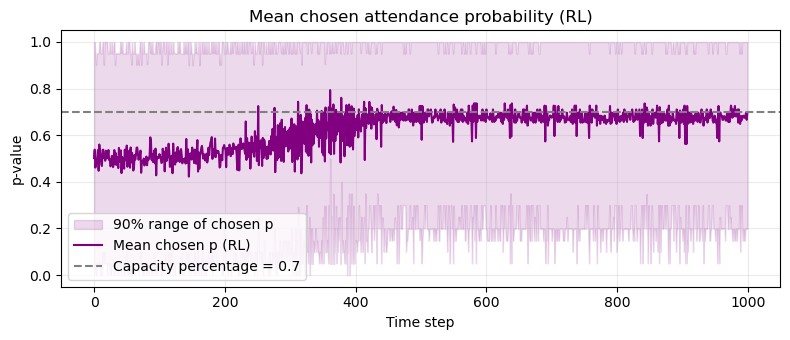

In [293]:

p_values_TM = res["chosen_history"] / M  # shape (T, N)


# Compute 5th and 95th percentiles across agents
p05 = np.percentile(p_values_TM, 5, axis=1)
p95 = np.percentile(p_values_TM, 95, axis=1)

plt.figure(figsize=(8, 3.5))

# 90% range shading
plt.fill_between(
    np.arange(len(mean_p)), 
    p05, p95, 
    color='purple', 
    alpha=0.15, 
    label='90% range of chosen p'
)

# Mean line
plt.plot(mean_p, label='Mean chosen p (RL)', color='purple')

# Capacity threshold
plt.axhline(C_frac, color='gray', linestyle='--', label=f'Capacity percentage = {C_frac}')

plt.title("Mean chosen attendance probability (RL)")
plt.xlabel("Time step")
plt.ylabel("p-value")
plt.legend()
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()


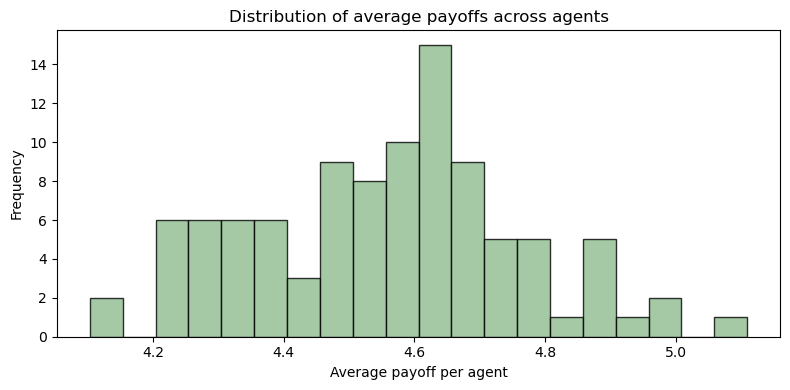

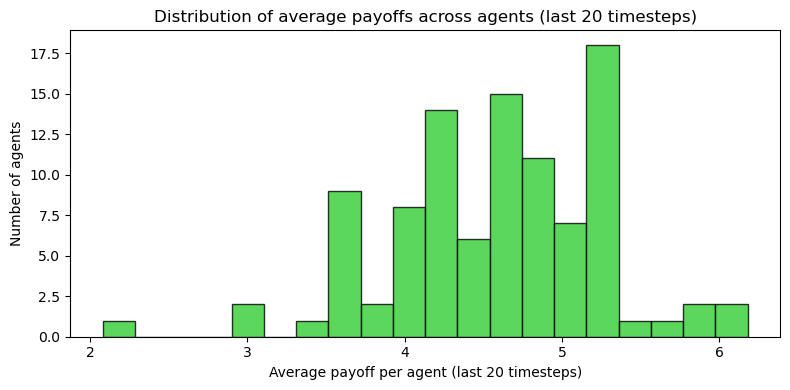

In [308]:
# Compute each agent’s average payoff over the full run
agent_avg_payoffs = res["all_payoffs"].mean(axis=0)

plt.figure(figsize=(8, 4))
plt.hist(agent_avg_payoffs, bins=20, color="darkseagreen", edgecolor="black", alpha=0.8)
plt.xlabel("Average payoff per agent")
plt.ylabel("Frequency")
plt.title("Distribution of average payoffs across agents")
plt.tight_layout()
plt.show()


# --- Compute average payoff across the last 10 timesteps for each agent ---
last_window = 20  # number of final timesteps to average
last_10_avg_payoffs = res["all_payoffs"][-last_window:, :].mean(axis=0)

# --- Plot: Histogram of average payoffs across agents (last 10 timesteps) ---
plt.figure(figsize=(8, 4))
plt.hist(last_10_avg_payoffs, bins=20, color="limegreen", edgecolor="black", alpha=0.8)
plt.xlabel("Average payoff per agent (last 20 timesteps)")
plt.ylabel("Number of agents")
plt.title("Distribution of average payoffs across agents (last 20 timesteps)")
plt.tight_layout()
plt.show()

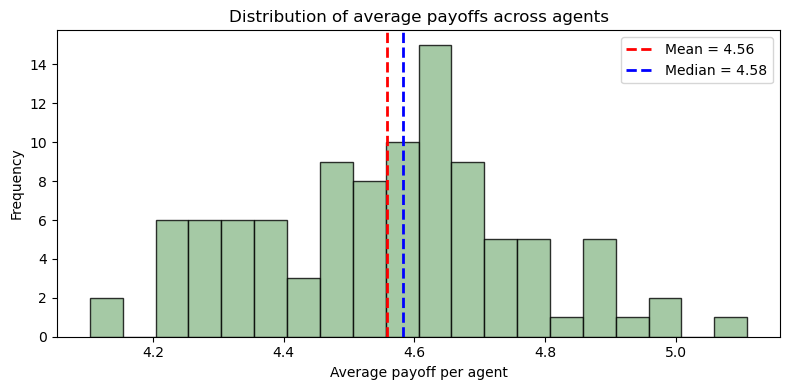

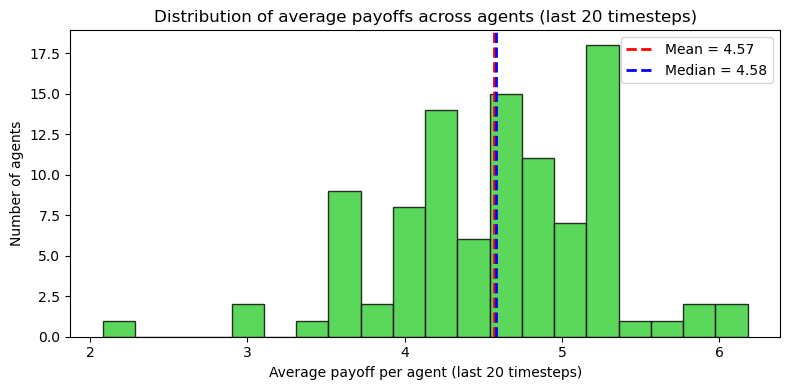

In [316]:
# Compute each agent’s average payoff over the full run
agent_avg_payoffs = res["all_payoffs"].mean(axis=0)

mean_val = agent_avg_payoffs.mean()
median_val = np.median(agent_avg_payoffs)

plt.figure(figsize=(8, 4))
plt.hist(agent_avg_payoffs, bins=20, color="darkseagreen", edgecolor="black", alpha=0.8)

# --- Add mean and median lines ---
plt.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_val:.2f}")
plt.axvline(median_val, color="blue", linestyle="--", linewidth=2, label=f"Median = {median_val:.2f}")

plt.xlabel("Average payoff per agent")
plt.ylabel("Frequency")
plt.title("Distribution of average payoffs across agents")
plt.legend()
plt.tight_layout()
plt.show()

# --- Compute average payoff across the last 20 timesteps for each agent ---
last_window = 20
last_20_avg_payoffs = res["all_payoffs"][-last_window:, :].mean(axis=0)

mean_val_last = last_20_avg_payoffs.mean()
median_val_last = np.median(last_20_avg_payoffs)

plt.figure(figsize=(8, 4))
plt.hist(last_20_avg_payoffs, bins=20, color="limegreen", edgecolor="black", alpha=0.8)

# --- Add mean and median lines ---
plt.axvline(mean_val_last, color="red", linestyle="--", linewidth=2,
            label=f"Mean = {mean_val_last:.2f}")
plt.axvline(median_val_last, color="blue", linestyle="--", linewidth=2,
            label=f"Median = {median_val_last:.2f}")

plt.xlabel("Average payoff per agent (last 20 timesteps)")
plt.ylabel("Number of agents")
plt.title("Distribution of average payoffs across agents (last 20 timesteps)")
plt.legend()
plt.tight_layout()
plt.show()


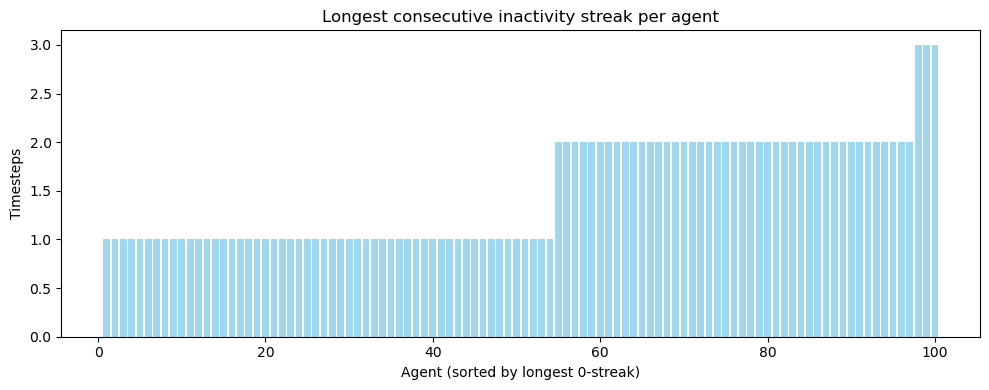

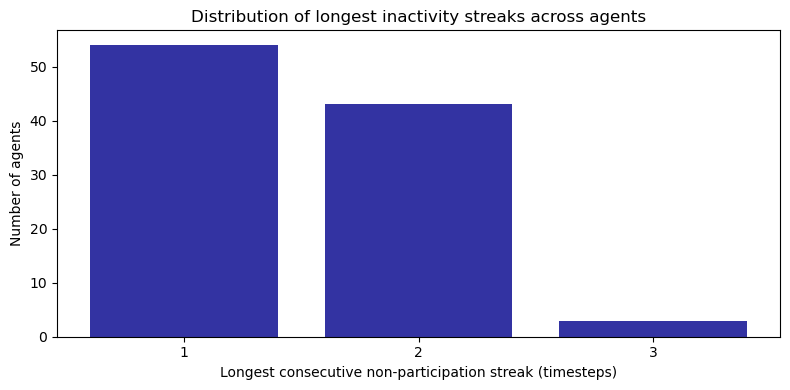

In [295]:
actions = res["chosen_history"]  # shape (T, N) - try with chosen action counts it give fun results 
N = actions.shape[1]

longest_zero_streaks = np.zeros(N, dtype=int)

for i in range(N):
    longest = current = 0
    for a in actions[:, i]:
        if a == 0:
            current += 1
            longest = max(longest, current)
        else:
            current = 0
    longest_zero_streaks[i] = longest


# --- Sorted bar plot ---
plt.figure(figsize=(10, 4))
plt.bar(np.arange(N)+1, np.sort(longest_zero_streaks), color="skyblue", alpha=0.8)
plt.xlabel("Agent (sorted by longest 0-streak)")
plt.ylabel("Timesteps")
plt.title("Longest consecutive inactivity streak per agent")
plt.tight_layout()
plt.show()  


# Convert streak lengths into a bar plot
unique_streaks, counts = np.unique(longest_zero_streaks, return_counts=True)

plt.figure(figsize=(8, 4))
plt.bar(unique_streaks, counts, color="darkblue", alpha=0.8)

plt.xlabel("Longest consecutive non-participation streak (timesteps)")
plt.ylabel("Number of agents")
plt.title("Distribution of longest inactivity streaks across agents")

plt.xticks(unique_streaks)  # show every streak value
plt.tight_layout()
plt.show()






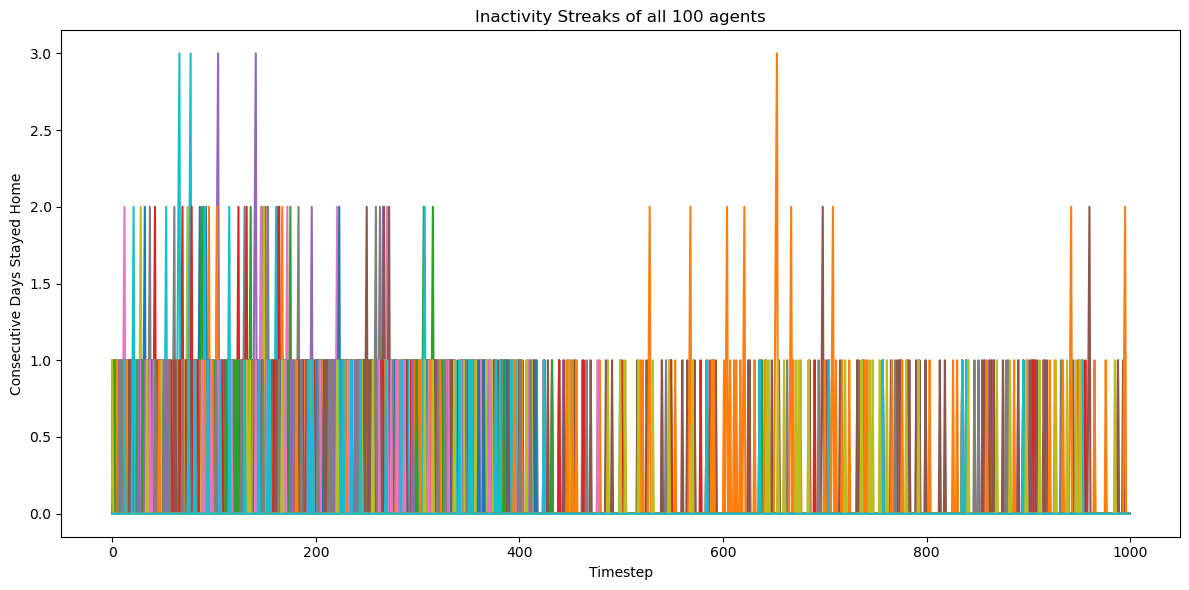

In [ ]:
def plot_inactivity_streaks(chosen_history, n_agents=3, seed=0):
    """
    Plots inactivity streaks (consecutive days of staying home)
    for n randomly chosen agents.
    
    Parameters:
    - actions_history: array of shape (T, N), entries in {0,1}
    - n_agents: number of agents to plot streaks for
    - seed: random seed for agent selection
    """

    np.random.seed(seed)
    T, N = chosen_history.shape
    
    # Choose random agents
    chosen_agents = np.random.choice(N, size=n_agents, replace=False)
    
    # Compute streaks
    streaks = np.zeros((T, n_agents), dtype=int)

    for idx, agent in enumerate(chosen_agents):
        streak = 0
        for t in range(T):
            if chosen_history[t, agent] == 0:
                streak += 1
            else:
                streak = 0
            streaks[t, idx] = streak

    # Plot
    plt.figure(figsize=(12, 6))
    for i in range(n_agents):
        plt.plot(streaks[:, i], label=f"Agent {chosen_agents[i]}")

    plt.xlabel("Timestep")
    plt.ylabel("Consecutive Days Stayed Home")
    plt.title(f"Inactivity Streaks of all {n_agents} agents")
    #plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
plot_inactivity_streaks(res["chosen_history"], n_agents=100)


In [309]:
def compare_parameter(param_name, values, plot_func, base_kwargs, ncols=3):
    """
    Generate subplots comparing simulation results across parameter values.

    Args:
        param_name: str, name of parameter to vary (e.g. 'rho')
        values: list of parameter values to test
        plot_func: function that takes (res, ax, label) and plots on the given axis
        base_kwargs: default kwargs for run_discrete_prob_rl
        ncols: number of columns in subplot grid
    """
    n = len(values)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3.5 * nrows), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, val in enumerate(values):
        kwargs = base_kwargs.copy()
        kwargs[param_name] = val
        print(f"Running {param_name}={val:.3f}")
        res = run_discrete_prob_rl(**kwargs)

        plot_func(res, axes[i], f"{param_name}={val:.3f}")

    # Clean up unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def plot_avg_payoff(res, ax, label):
    """
    Plot a histogram of average per-agent payoffs for a given RL run.
    """
    # Compute average payoff per agent across all timesteps
    agent_avg_payoffs = res["all_payoffs"].mean(axis=0)

    # Histogram (same style as the standalone version)
    ax.hist(agent_avg_payoffs, bins=20, color="darkseagreen",
            edgecolor="black", alpha=0.8)

    ax.set_title(f"{label} — Avg Payoff Distribution")
    ax.set_xlabel("Average payoff per agent")
    ax.set_ylabel("Frequency")
    ax.grid(True, alpha=0.25)


def plot_attendance(res, ax, label):
    ax.plot(res["attendance_ts"], color="tab:blue", lw=2, label=label)
    ax.set_title(label)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Attendance")

def plot_mean_p(res, ax, label):
    mean_p = res["mean_p_ts"]
    ax.plot(mean_p, color="tab:purple", lw=2)
    ax.set_title(label)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Mean p")


param_values_beta = [0.0, 0.5, 1.0, 1.5, 2.0] # above 1,875 should destroy learning

base_kwargs = dict(
    G=G, S=S, F=F, N=N, C=C, T=500, M=M, lr=LR, gamma=GAMMA,
    tau_start=TAU_START, tau_min=TAU_MIN,
    rho=rho, alpha=alpha, beta=0.5,
    bar_theta=bar_theta, theta_cap=theta_cap,
    k_init=K_INIT
)

#compare_parameter("beta", param_values_beta, plot_avg_payoff, base_kwargs, ncols=3)
#compare_parameter("beta", param_values_beta, plot_attendance, base_kwargs, ncols=3)
#compare_parameter("beta", param_values_beta, plot_mean_p, base_kwargs, ncols=3)



Running bar_theta=0.000
Running bar_theta=0.500
Running bar_theta=0.800
Running bar_theta=1.100
Running bar_theta=1.500


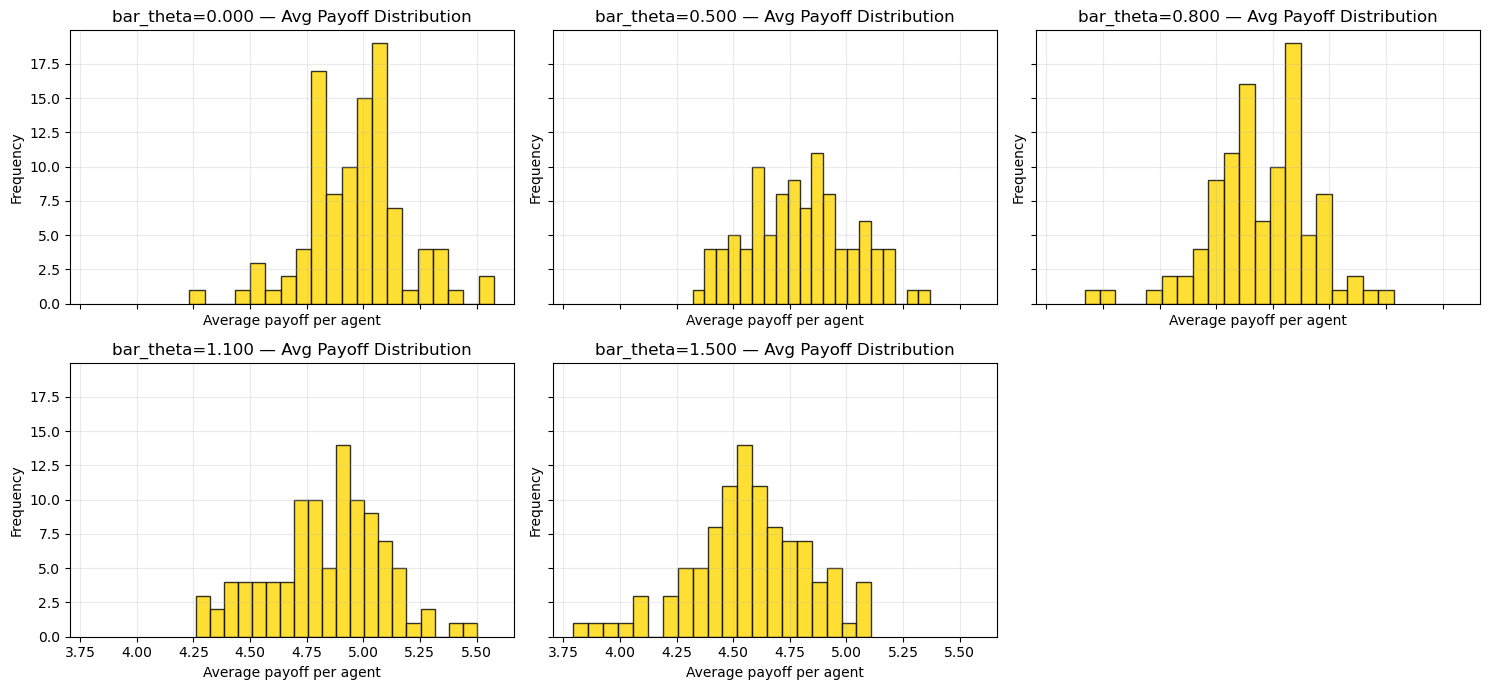

Running bar_theta=0.000
Running bar_theta=0.500
Running bar_theta=0.800
Running bar_theta=1.100
Running bar_theta=1.500


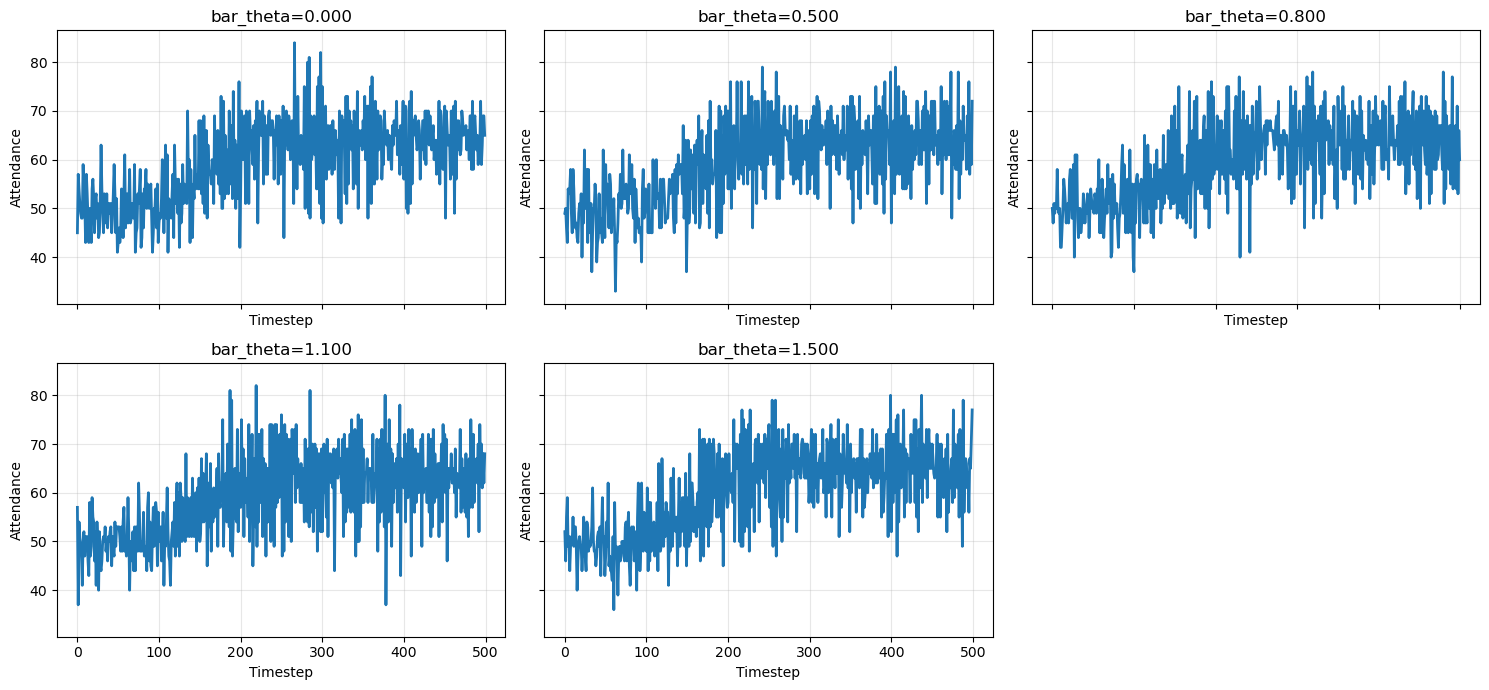

Running bar_theta=0.000
Running bar_theta=0.500
Running bar_theta=0.800
Running bar_theta=1.100
Running bar_theta=1.500


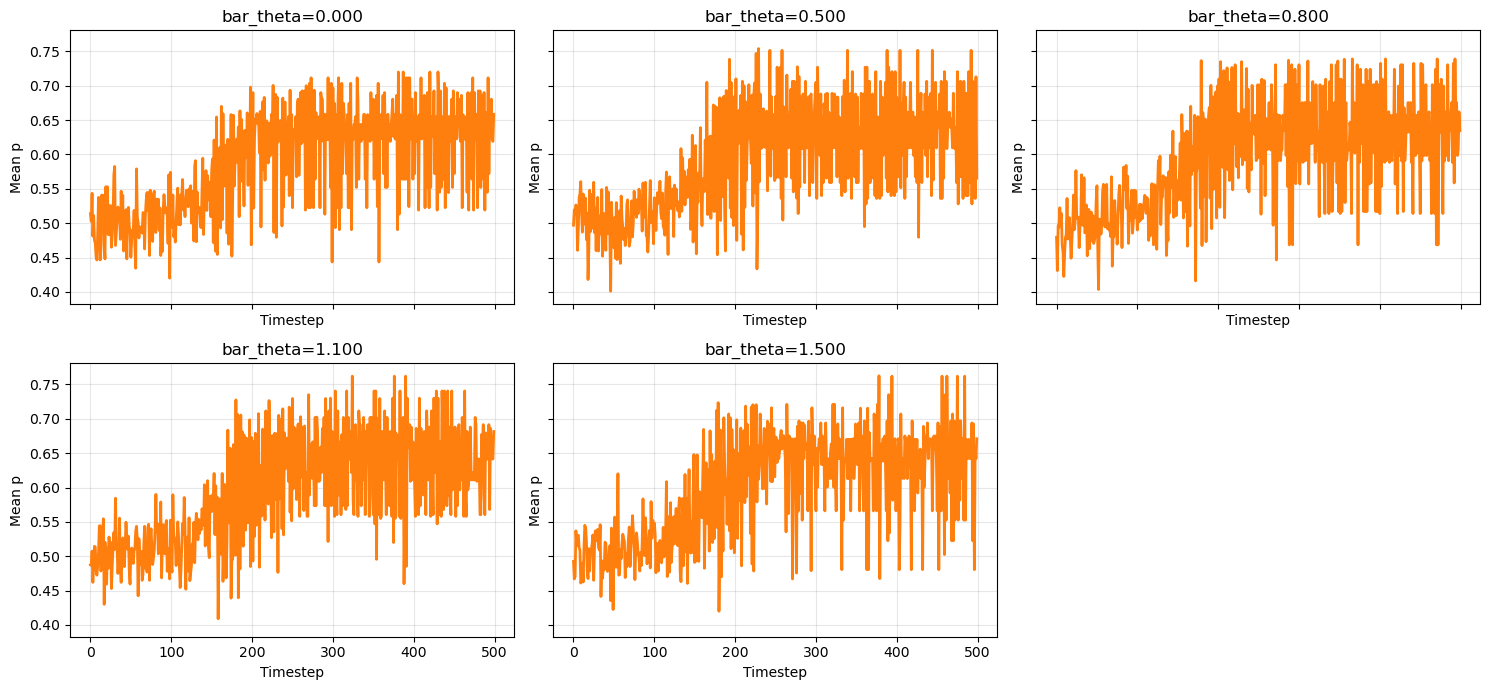

In [298]:
param_values_theta = [ 0.0, 0.5, 0.8, 1.1, 1.5]

base_kwargs = dict(
    G=G, S=S, F=F, N=N, C=C, T=500, M=M, lr=LR, gamma=GAMMA,
    tau_start=TAU_START, tau_min=TAU_MIN,
    rho=rho, alpha=alpha, beta=beta,
    bar_theta=0.8, theta_cap=theta_cap,
    k_init=K_INIT
)

compare_parameter("bar_theta", param_values_theta, plot_avg_payoff, base_kwargs, ncols=3)
compare_parameter("bar_theta", param_values_theta, plot_attendance, base_kwargs, ncols=3)
compare_parameter("bar_theta", param_values_theta, plot_mean_p, base_kwargs, ncols=3)


Running lr=0.001
Running lr=0.010
Running lr=0.100
Running lr=0.200
Running lr=0.300
Running lr=0.500


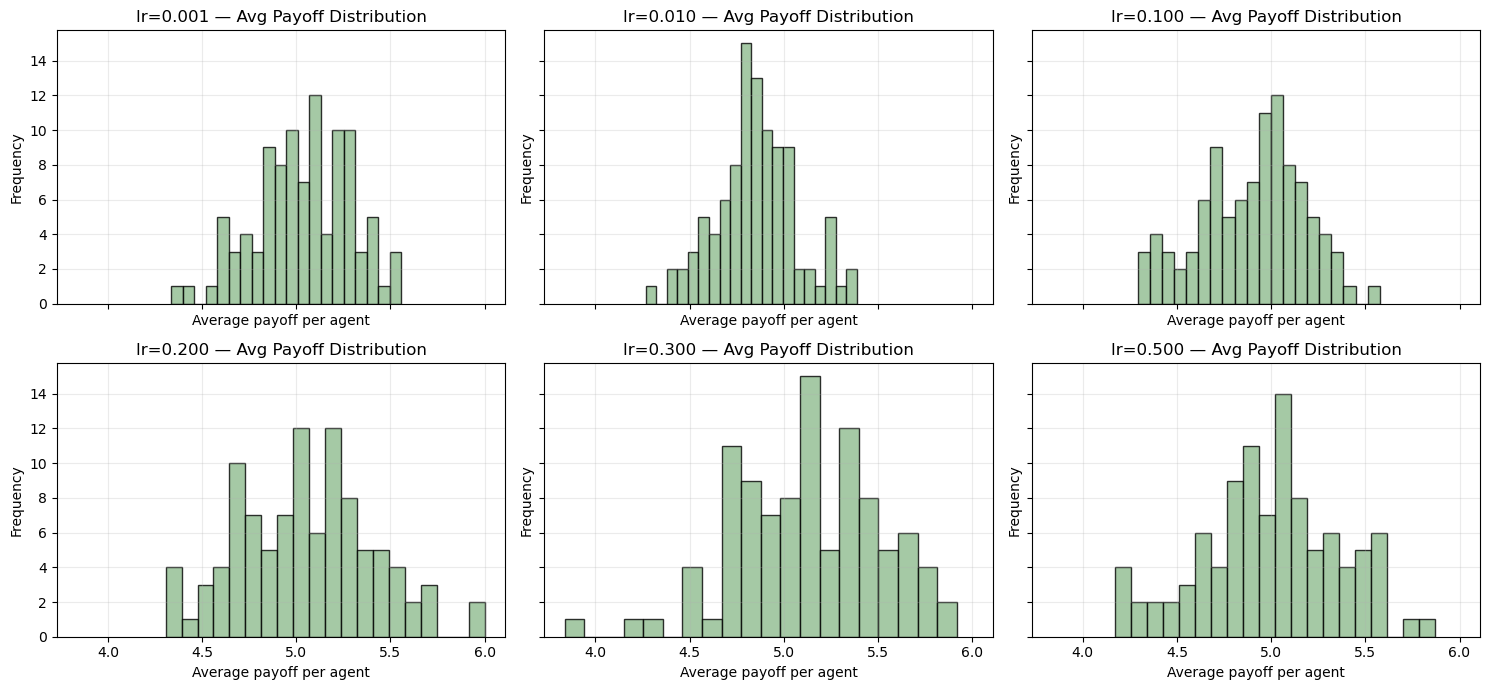

Running lr=0.001
Running lr=0.010
Running lr=0.100
Running lr=0.200
Running lr=0.300
Running lr=0.500


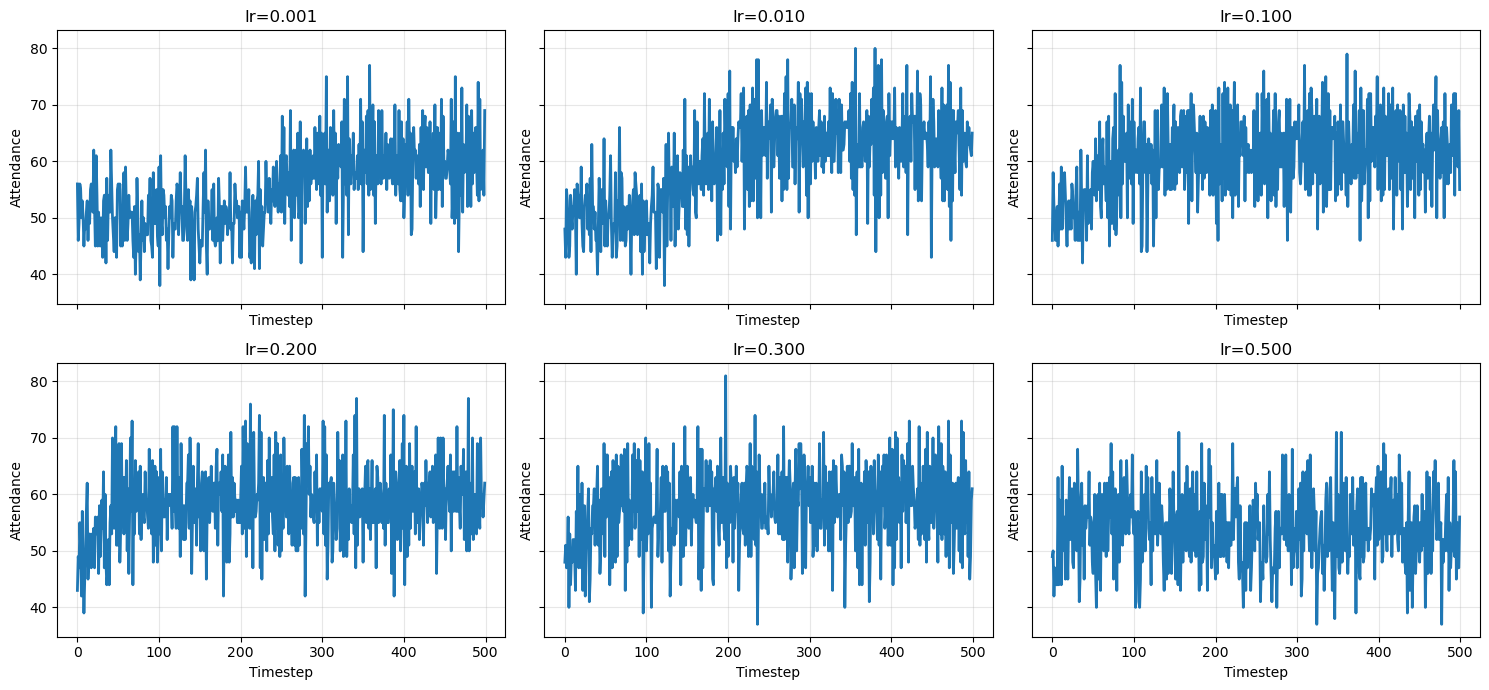

Running lr=0.001
Running lr=0.010
Running lr=0.100
Running lr=0.200
Running lr=0.300
Running lr=0.500


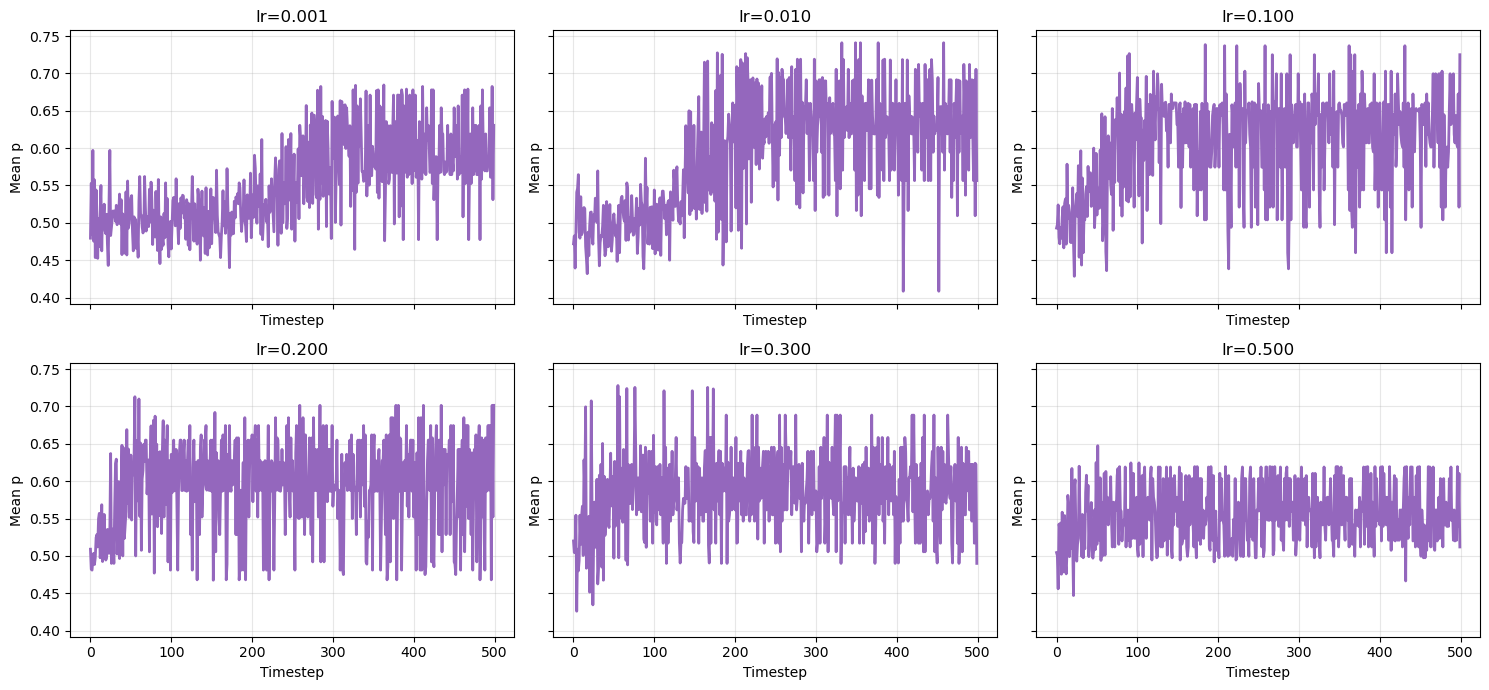

In [310]:
param_values_LR = [ 0.001, 0.01, 0.1, 0.2, 0.3, 0.5]

base_kwargs = dict(
    G=G, S=S, F=F, N=N, C=C, T=500, M=M, lr=0.01, gamma=GAMMA,
    tau_start=TAU_START, tau_min=TAU_MIN,
    rho=rho, alpha=alpha, beta=beta,
    bar_theta=bar_theta, theta_cap=theta_cap,
    k_init=K_INIT
)

compare_parameter("lr", param_values_LR, plot_avg_payoff, base_kwargs, ncols=3)
compare_parameter("lr", param_values_LR, plot_attendance, base_kwargs, ncols=3)
compare_parameter("lr", param_values_LR, plot_mean_p, base_kwargs, ncols=3)


Running gamma=0.100
Running gamma=0.300
Running gamma=0.500
Running gamma=0.700
Running gamma=0.900
Running gamma=1.000


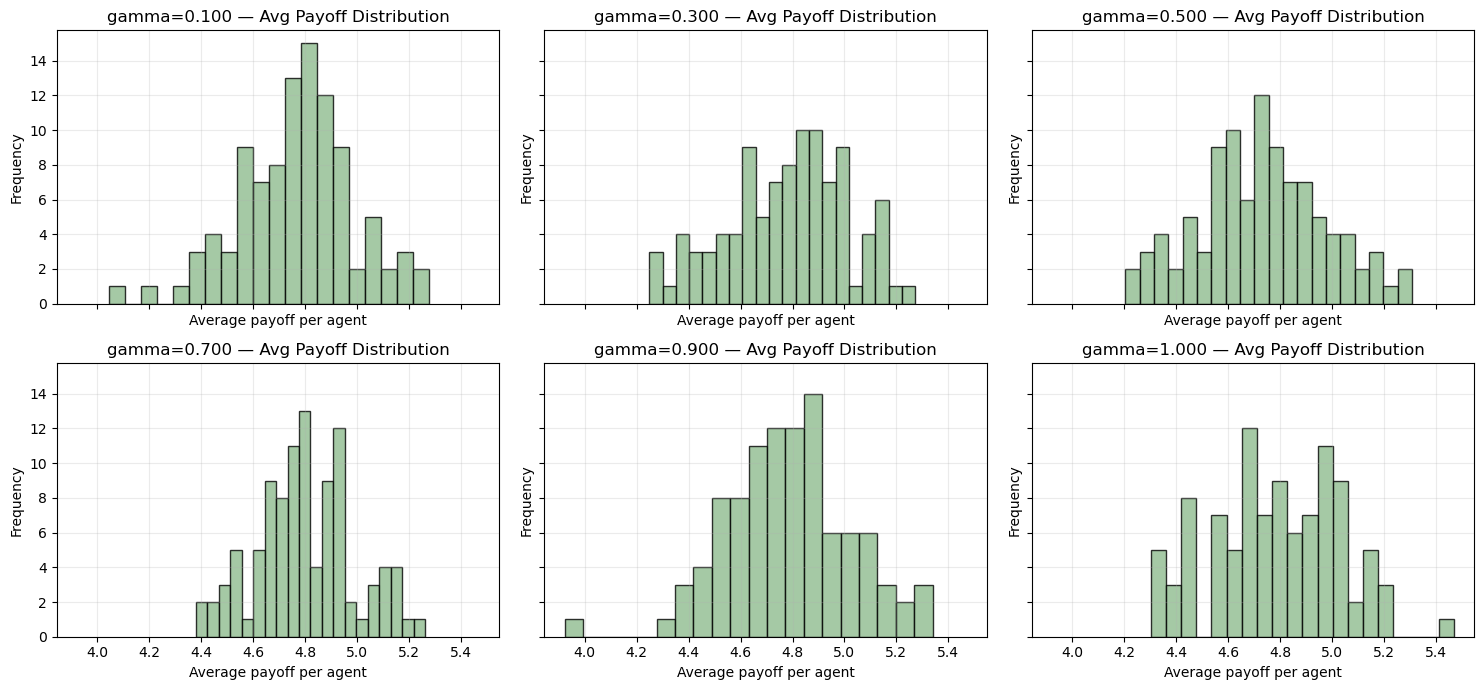

Running gamma=0.100
Running gamma=0.300
Running gamma=0.500
Running gamma=0.700
Running gamma=0.900
Running gamma=1.000


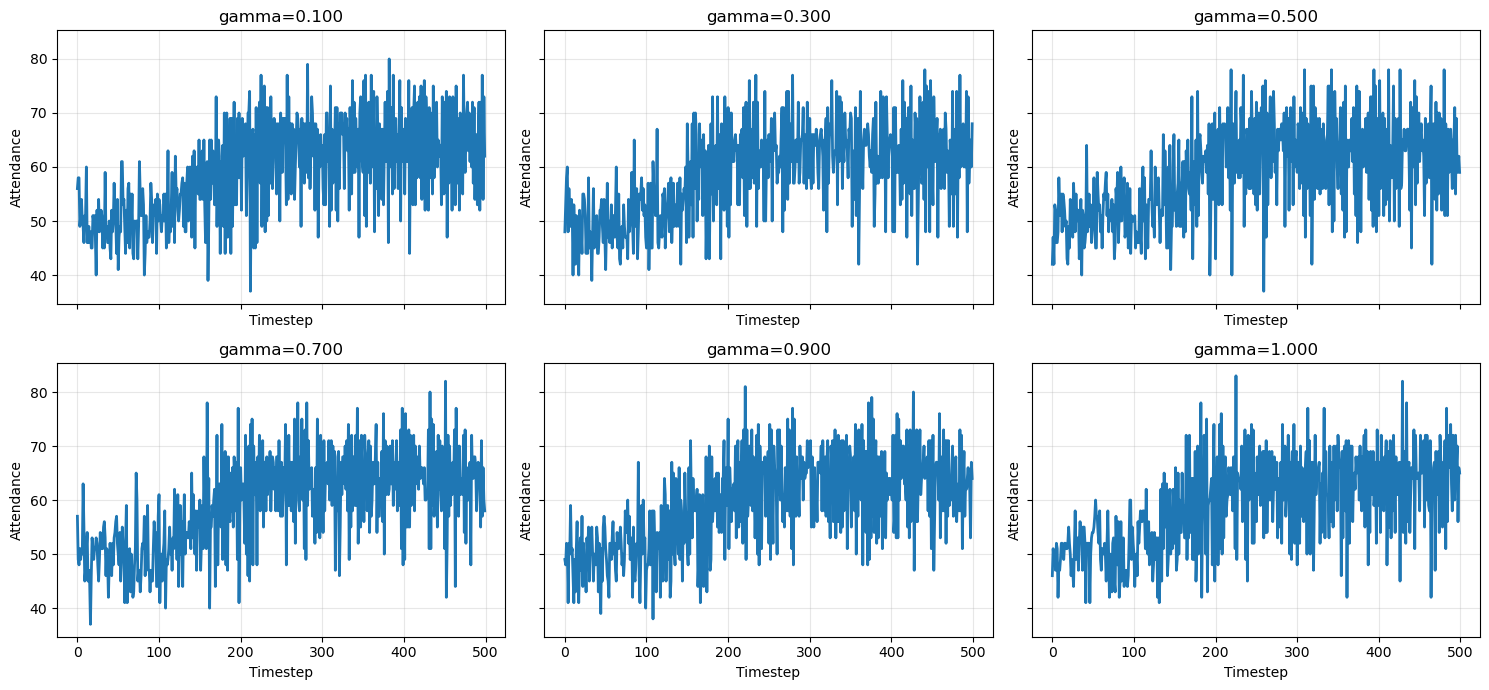

Running gamma=0.100
Running gamma=0.300
Running gamma=0.500
Running gamma=0.700
Running gamma=0.900
Running gamma=1.000


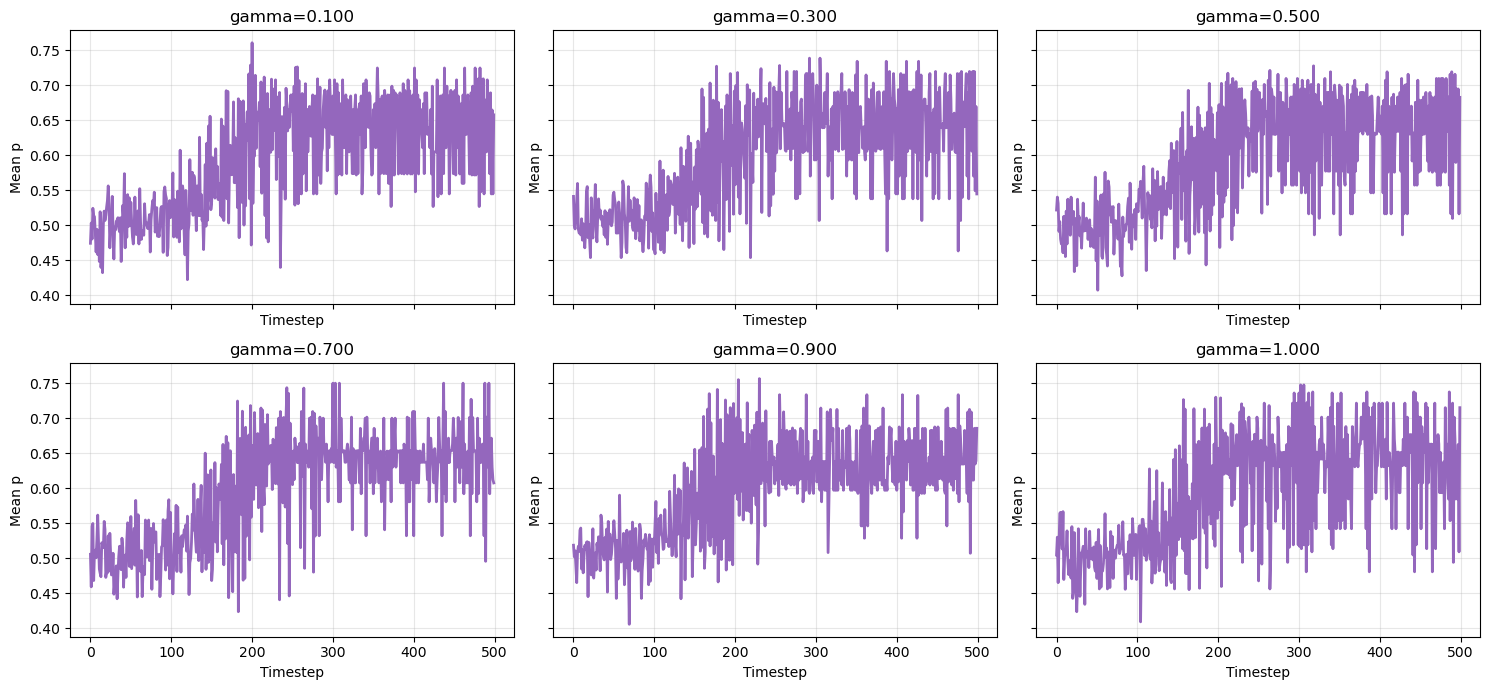

In [318]:
param_values_gamma = [ 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]

base_kwargs = dict(
    G=G, S=S, F=F, N=N, C=C, T=500, M=M, lr=LR, gamma=0.7,
    tau_start=TAU_START, tau_min=TAU_MIN,
    rho=rho, alpha=alpha, beta=beta,
    bar_theta=bar_theta, theta_cap=theta_cap,
    k_init=K_INIT
)

compare_parameter("gamma", param_values_gamma, plot_avg_payoff, base_kwargs, ncols=3)
compare_parameter("gamma", param_values_gamma, plot_attendance, base_kwargs, ncols=3)
compare_parameter("gamma", param_values_gamma, plot_mean_p, base_kwargs, ncols=3)

Running M=2.000
Running M=5.000
Running M=10.000
Running M=20.000
Running M=50.000
Running M=100.000


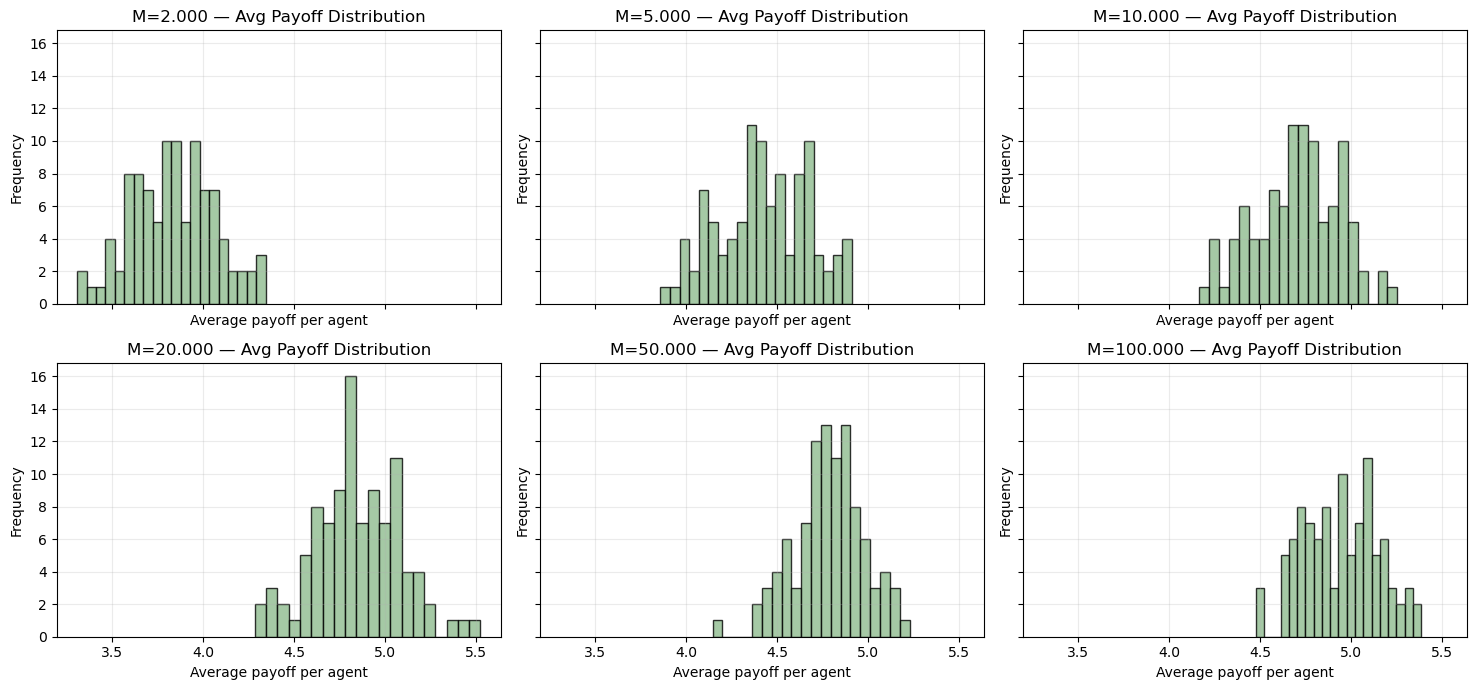

Running M=2.000
Running M=5.000
Running M=10.000
Running M=20.000
Running M=50.000
Running M=100.000


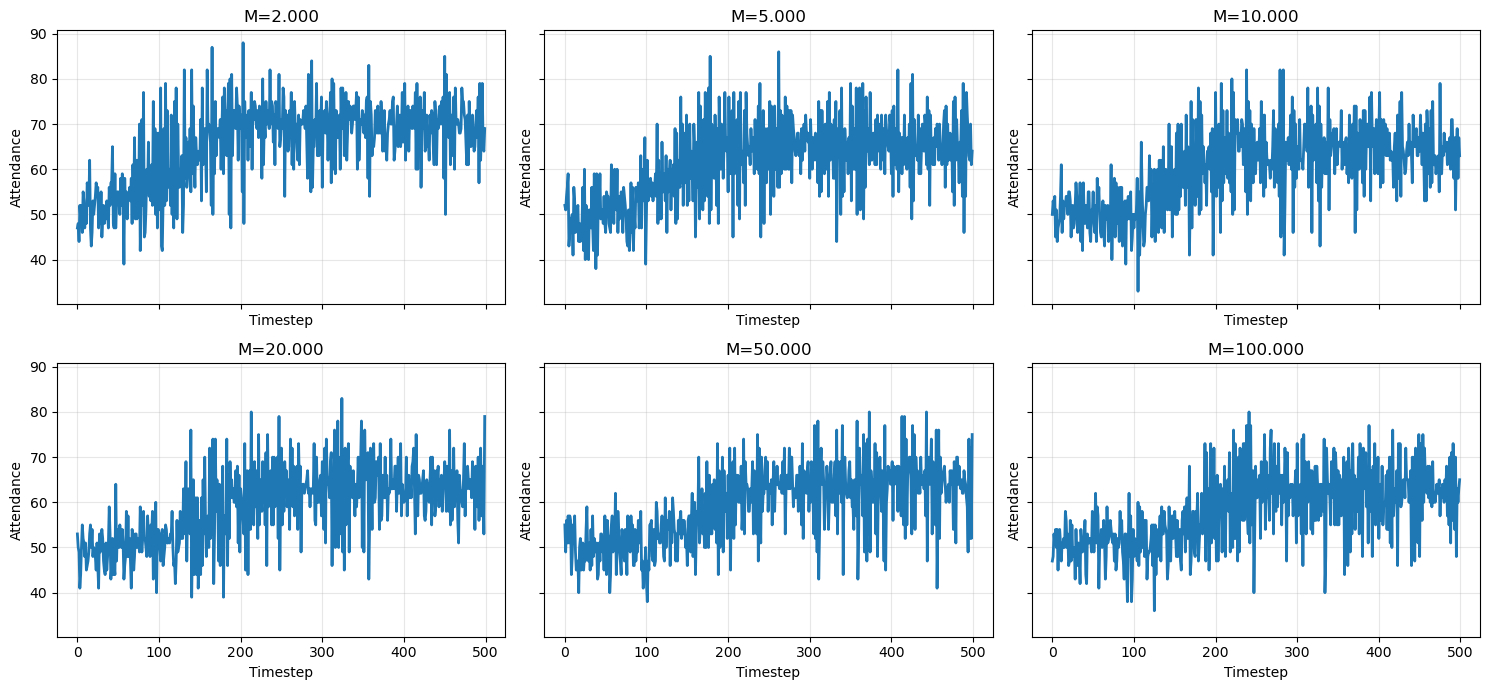

Running M=2.000
Running M=5.000
Running M=10.000
Running M=20.000
Running M=50.000
Running M=100.000


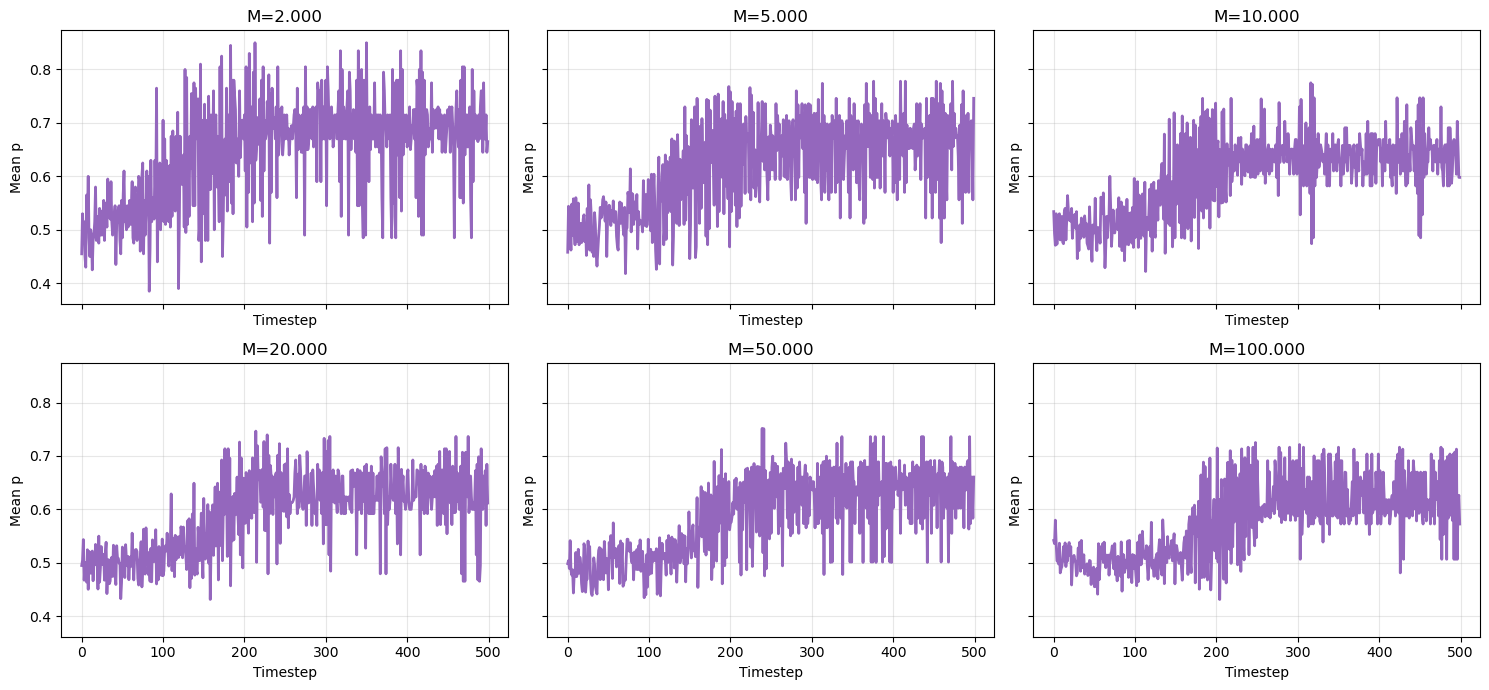

In [317]:
param_values_M = [ 2, 5, 10, 20, 50, 100]

base_kwargs = dict(
    G=G, S=S, F=F, N=N, C=C, T=500, M=20, lr=LR, gamma=GAMMA,
    tau_start=TAU_START, tau_min=TAU_MIN,
    rho=rho, alpha=alpha, beta=beta,
    bar_theta=bar_theta, theta_cap=theta_cap,
    k_init=K_INIT
)

compare_parameter("M", param_values_M, plot_avg_payoff, base_kwargs, ncols=3)
compare_parameter("M", param_values_M, plot_attendance, base_kwargs, ncols=3)
compare_parameter("M", param_values_M, plot_mean_p, base_kwargs, ncols=3)

Running G=6.000, S=2.000
Running G=7.500, S=2.000
Running G=9.000, S=2.000
Running G=10.500, S=2.000
Running G=12.000, S=2.000
Running G=6.000, S=2.750
Running G=7.500, S=2.750
Running G=9.000, S=2.750
Running G=10.500, S=2.750
Running G=12.000, S=2.750
Running G=6.000, S=3.500
Running G=7.500, S=3.500
Running G=9.000, S=3.500
Running G=10.500, S=3.500
Running G=12.000, S=3.500
Running G=6.000, S=4.250
Running G=7.500, S=4.250
Running G=9.000, S=4.250
Running G=10.500, S=4.250
Running G=12.000, S=4.250
Running G=6.000, S=5.000
Running G=7.500, S=5.000
Running G=9.000, S=5.000
Running G=10.500, S=5.000
Running G=12.000, S=5.000


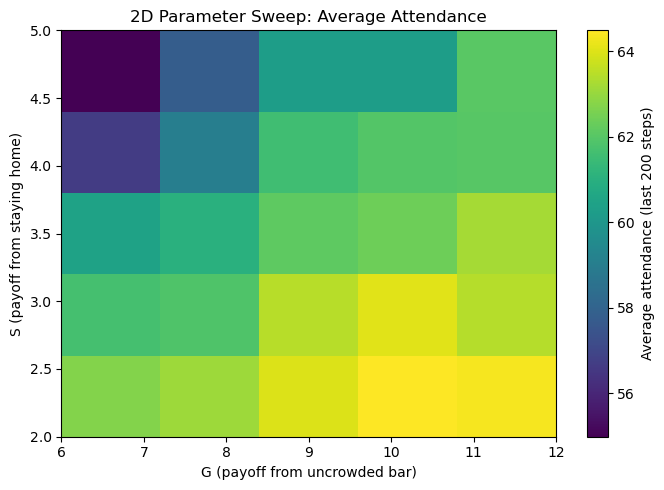

In [300]:
import itertools

def sweep_2d(param_x, values_x, param_y, values_y, summary_func, **base_kwargs):

    results = np.zeros((len(values_y), len(values_x)))
    for j, yval in enumerate(values_y):
        for i, xval in enumerate(values_x):
            kwargs = base_kwargs.copy()
            kwargs[param_x] = xval
            kwargs[param_y] = yval
            print(f"Running {param_x}={xval:.3f}, {param_y}={yval:.3f}")
            res = run_discrete_prob_rl(**kwargs)
            results[j, i] = summary_func(res)
    return results

def avg_attendance(res):
    return np.mean(res["attendance_ts"][-200:])  # average attendance over last 200 steps

def avg_payoff(res):
    return np.mean(res["avg_payoff_ts"][-200:])  # mean payoff in steady state

def avg_inactivity(res):
    # fraction of time agents are inactive near the end
    actions = (res["chosen_history"] > 0).astype(int)
    inactive = 1 - actions.mean(axis=1)
    return np.mean(inactive[-200:])

G_values = np.linspace(6, 12, 5)
S_values = np.linspace(2, 5, 5)
F_values = np.linspace(0.1, 1.5, 5)

heatmap_data_GS = sweep_2d("G", G_values, "S", S_values,
                        summary_func=avg_attendance, F=F,
                        N=N, C=C, T=500, M=M, lr=LR, gamma=GAMMA,
                        tau_start=TAU_START, tau_min=TAU_MIN, rho=rho,
                        alpha=alpha, beta=beta, bar_theta=bar_theta,
                        theta_cap=theta_cap, k_init=K_INIT)


plt.figure(figsize=(7, 5))
im = plt.imshow(heatmap_data_GS, origin='lower', aspect='auto',
                extent=[G_values[0], G_values[-1], S_values[0], S_values[-1]],
                cmap='viridis')
plt.colorbar(im, label="Average attendance (last 200 steps)")
plt.xlabel("G (payoff from uncrowded bar)")
plt.ylabel("S (payoff from staying home)")
plt.title("2D Parameter Sweep: Average Attendance")
plt.tight_layout()
plt.show()





Running G=6.000, F=0.100
Running G=7.500, F=0.100
Running G=9.000, F=0.100
Running G=10.500, F=0.100
Running G=12.000, F=0.100
Running G=6.000, F=0.450
Running G=7.500, F=0.450
Running G=9.000, F=0.450
Running G=10.500, F=0.450
Running G=12.000, F=0.450
Running G=6.000, F=0.800
Running G=7.500, F=0.800
Running G=9.000, F=0.800
Running G=10.500, F=0.800
Running G=12.000, F=0.800
Running G=6.000, F=1.150
Running G=7.500, F=1.150
Running G=9.000, F=1.150
Running G=10.500, F=1.150
Running G=12.000, F=1.150
Running G=6.000, F=1.500
Running G=7.500, F=1.500
Running G=9.000, F=1.500
Running G=10.500, F=1.500
Running G=12.000, F=1.500


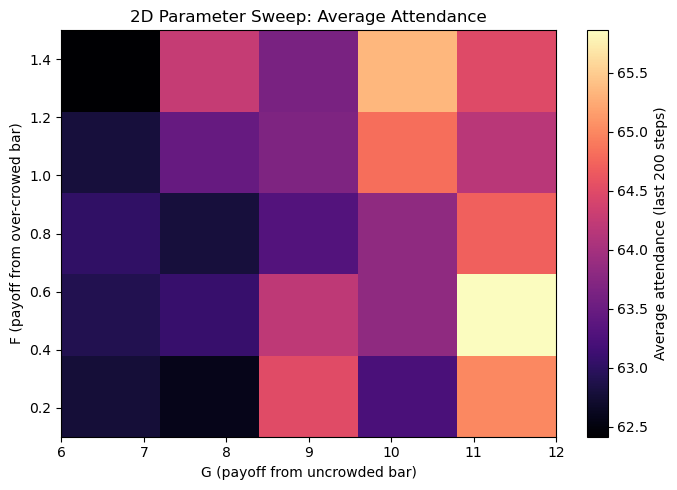

In [301]:
heatmap_data_GF = sweep_2d("G", G_values, "F", F_values,
                        summary_func=avg_attendance, S=S,
                        N=N, C=C, T=500, M=M, lr=LR, gamma=GAMMA,
                        tau_start=TAU_START, tau_min=TAU_MIN, rho=rho,
                        alpha=alpha, beta=beta, bar_theta=bar_theta,
                        theta_cap=theta_cap, k_init=K_INIT)

plt.figure(figsize=(7, 5))
im = plt.imshow(heatmap_data_GF, origin='lower', aspect='auto',
                extent=[G_values[0], G_values[-1], F_values[0], F_values[-1]],
                cmap='magma')
plt.colorbar(im, label="Average attendance (last 200 steps)")
plt.xlabel("G (payoff from uncrowded bar)")
plt.ylabel("F (payoff from over-crowed bar)")
plt.title("2D Parameter Sweep: Average Attendance")
plt.tight_layout()
plt.show()

Running rho=0.100, beta=0.100
Running rho=0.250, beta=0.100
Running rho=0.400, beta=0.100
Running rho=0.550, beta=0.100
Running rho=0.700, beta=0.100
Running rho=0.100, beta=0.325
Running rho=0.250, beta=0.325
Running rho=0.400, beta=0.325
Running rho=0.550, beta=0.325
Running rho=0.700, beta=0.325
Running rho=0.100, beta=0.550
Running rho=0.250, beta=0.550
Running rho=0.400, beta=0.550
Running rho=0.550, beta=0.550
Running rho=0.700, beta=0.550
Running rho=0.100, beta=0.775
Running rho=0.250, beta=0.775
Running rho=0.400, beta=0.775
Running rho=0.550, beta=0.775
Running rho=0.700, beta=0.775
Running rho=0.100, beta=1.000
Running rho=0.250, beta=1.000
Running rho=0.400, beta=1.000
Running rho=0.550, beta=1.000
Running rho=0.700, beta=1.000


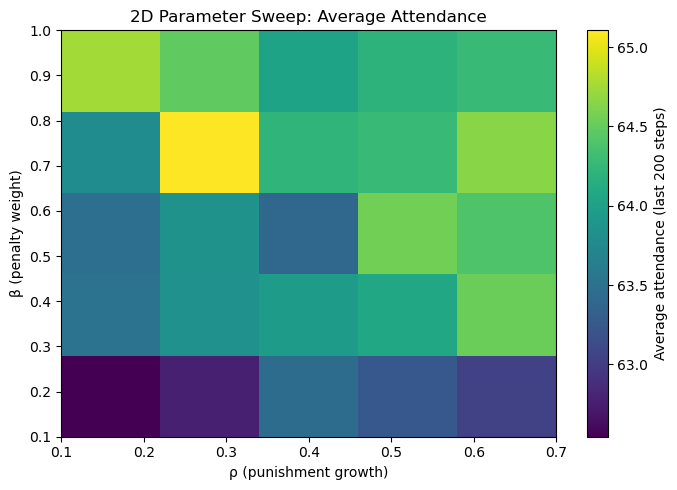

In [302]:
def sweep_2d(param_x, values_x, param_y, values_y, summary_func, **base_kwargs):
    """
    Run 2D parameter sweep and return a matrix of summary statistics.

    Args:
        param_x, param_y: Names of parameters to vary
        values_x, values_y: Lists of parameter values
        summary_func: Function that takes simulation results and returns a single number
        base_kwargs: Default args for run_discrete_prob_rl

    Returns:
        np.ndarray of shape (len(values_y), len(values_x))
    """
    results = np.zeros((len(values_y), len(values_x)))
    for j, yval in enumerate(values_y):
        for i, xval in enumerate(values_x):
            kwargs = base_kwargs.copy()
            kwargs[param_x] = xval
            kwargs[param_y] = yval
            print(f"Running {param_x}={xval:.3f}, {param_y}={yval:.3f}")
            res = run_discrete_prob_rl(**kwargs)
            results[j, i] = summary_func(res)
    return results

def avg_attendance(res):
    return np.mean(res["attendance_ts"][-200:])  # average attendance over last 200 steps

def avg_payoff(res):
    return np.mean(res["avg_payoff_ts"][-200:])  # mean payoff in steady state

def avg_inactivity(res):
    # fraction of time agents are inactive near the end
    actions = (res["chosen_history"] > 0).astype(int)
    inactive = 1 - actions.mean(axis=1)
    return np.mean(inactive[-200:])

rho_values = np.linspace(0.1, 0.7, 5)
beta_values = np.linspace(0.1, 1.0, 5)


heatmap_data = sweep_2d("rho", rho_values, "beta", beta_values,
                        summary_func=avg_attendance,
                        N=N, C=C, T=500, M=M, lr=LR, gamma=GAMMA,
                        tau_start=TAU_START, tau_min=TAU_MIN,
                        alpha=alpha, bar_theta=bar_theta,
                        theta_cap=theta_cap, k_init=K_INIT)


plt.figure(figsize=(7, 5))
im = plt.imshow(heatmap_data, origin='lower', aspect='auto',
                extent=[rho_values[0], rho_values[-1], beta_values[0], beta_values[-1]],
                cmap='viridis')
plt.colorbar(im, label="Average attendance (last 200 steps)")
plt.xlabel("ρ (punishment growth)")
plt.ylabel("β (penalty weight)")
plt.title("2D Parameter Sweep: Average Attendance")
plt.tight_layout()
plt.show()





Running S=2.000, F=0.100
Running S=2.750, F=0.100
Running S=3.500, F=0.100
Running S=4.250, F=0.100
Running S=5.000, F=0.100
Running S=2.000, F=0.450
Running S=2.750, F=0.450
Running S=3.500, F=0.450
Running S=4.250, F=0.450
Running S=5.000, F=0.450
Running S=2.000, F=0.800
Running S=2.750, F=0.800
Running S=3.500, F=0.800
Running S=4.250, F=0.800
Running S=5.000, F=0.800
Running S=2.000, F=1.150
Running S=2.750, F=1.150
Running S=3.500, F=1.150
Running S=4.250, F=1.150
Running S=5.000, F=1.150
Running S=2.000, F=1.500
Running S=2.750, F=1.500
Running S=3.500, F=1.500
Running S=4.250, F=1.500
Running S=5.000, F=1.500


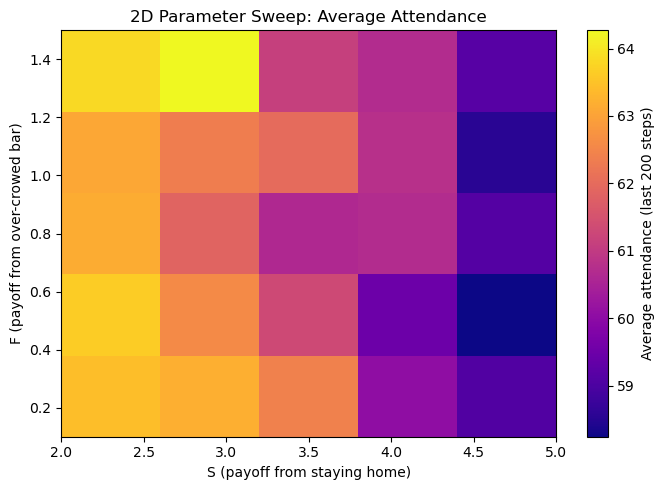

In [337]:

heatmap_data_SF = sweep_2d("S", S_values, "F", F_values,
                        summary_func=avg_attendance, G=G,
                        N=N, C=C, T=500, M=M, lr=LR, gamma=GAMMA,
                        tau_start=TAU_START, tau_min=TAU_MIN, rho=rho,
                        alpha=alpha, beta=beta, bar_theta=bar_theta,
                        theta_cap=theta_cap, k_init=K_INIT)

plt.figure(figsize=(7, 5))
im = plt.imshow(heatmap_data_SF, origin='lower', aspect='auto',
                extent=[S_values[0], S_values[-1], F_values[0], F_values[-1]],
                cmap='plasma')
plt.colorbar(im, label="Average attendance (last 200 steps)")
plt.xlabel("S (payoff from staying home)")
plt.ylabel("F (payoff from over-crowed bar)")
plt.title("2D Parameter Sweep: Average Attendance")
plt.tight_layout()
plt.show()

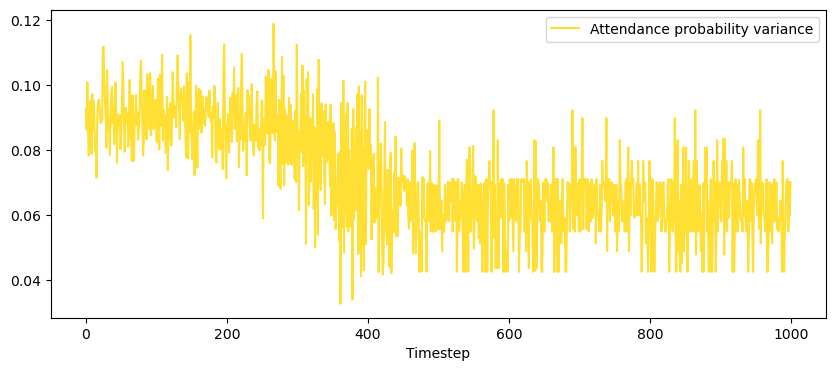

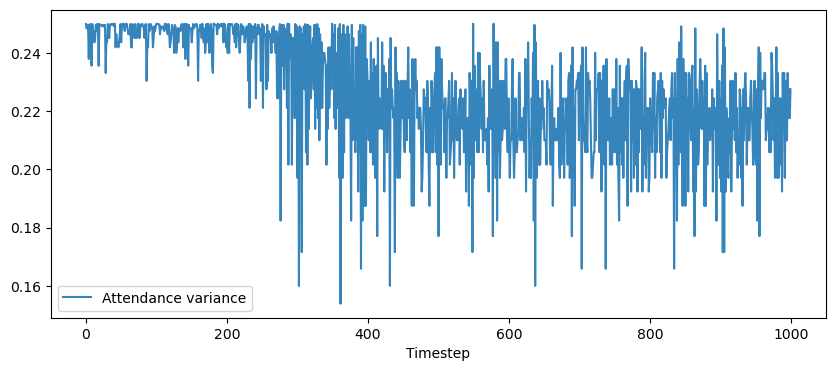

In [333]:
t = np.arange(len(res["p_var"]))

plt.figure(figsize=(10,4))
plt.plot(t, res["p_var"], color = "gold", label="Attendance probability variance", alpha=0.8)
plt.xlabel("Timestep")
plt.legend()
plt.show()


plt.figure(figsize=(10,4))
plt.plot(t, res["attendance_var_ts"], label="Attendance variance", alpha=0.9)
plt.xlabel("Timestep")
plt.legend()
plt.show()